In [63]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import folium
from folium.plugins import Fullscreen, MeasureControl
import numpy as np

In [30]:
# Initialize geolocator for country detection
geolocator = Nominatim(user_agent="flight_route_analyzer")

In [31]:
# Function to get country from city
def get_country(city):
    try:
        location = geolocator.geocode(city, timeout=10)
        if location:
            address = location.raw.get('address', {})
            return address.get('country', 'Unknown')
        return 'Unknown'
    except GeocoderTimedOut:
        return 'Unknown'

In [32]:
# URL of the Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_busiest_passenger_flight_routes"

# Send a GET request to fetch the page
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

In [33]:
# Initialize a list to store the flight data
flights = []

In [34]:
def clean_passengers(passenger_text):
    cleaned = re.sub(r'\[\d+\]', '', passenger_text).replace(',', '').strip()
    try:
        return int(cleaned)
    except ValueError:
        return None

In [35]:
# Function to extract year from table context
def get_table_year(table):
    caption = table.find_previous(["h2", "h3"])
    if caption:
        match = re.search(r'\b(20\d{2})\b', caption.text)
        if match:
            return match.group(1)
    caption = table.find("caption")
    if caption:
        match = re.search(r'\b(20\d{2})\b', caption.text)
        if match:
            return match.group(1)
    return None

In [36]:
# Find all tables with class 'wikitable'
tables = soup.find_all("table", class_="wikitable")

In [37]:
# Function to get country and coordinates from city
def get_location(city):
    try:
        location = geolocator.geocode(city, timeout=10)
        if location:
            address = location.raw.get('address', {})
            country = address.get('country', 'Unknown')
            return country, location.latitude, location.longitude
        return 'Unknown', None, None
    except GeocoderTimedOut:
        return 'Unknown', None, None

# Process each table
for table in tables:
    # Determine route type based on table context
    caption = table.find_previous(["h2", "h3"])
    route_type = "Unknown"  # Default
    if caption and "Domestic" in caption.text:
        route_type = "Domestic"
    elif caption and "International" in caption.text:
        route_type = "International"    
    
    # Get table year
    table_year = get_table_year(table)
    
    # Get headers to identify column indices
    headers = table.find("tr").find_all(["th", "td"])
    col_indices = {
        "from": None,
        "to": None,
        "passengers": None,
        "year": None
    }
    
    # Identify relevant columns
    for i, header in enumerate(headers):
        header_text = header.text.strip().lower()
        if "airport" in header_text or "city" in header_text:
            if col_indices["from"] is None:
                col_indices["from"] = i
            else:
                col_indices["to"] = i
        elif "passenger" in header_text:
            col_indices["passengers"] = i
        elif "year" in header_text:
            col_indices["year"] = i
    
    # Get all rows in the table body
    rows = table.find("tbody").find_all("tr")[1:]  # Skip header row
    
    for row in rows:
        cols = row.find_all("td")
        if len(cols) >= 3:  # Ensure enough columns
            # Extract data
            from_city = cols[col_indices["from"]].text.strip() if col_indices["from"] is not None else None
            to_city = cols[col_indices["to"]].text.strip() if col_indices["to"] is not None else None
            passengers = clean_passengers(cols[col_indices["passengers"]].text.strip()) if col_indices["passengers"] is not None else None
            year = cols[col_indices["year"]].text.strip() if col_indices["year"] is not None else table_year
            
            # Skip rows with missing critical data
            if from_city and to_city and passengers and year:
                # Clean city names (remove airport codes, extra info, state codes)
                from_city = re.sub(r'\([^)]*\)|\b[A-Z]{3}\b|\b[A-Z]{2}\b', '', from_city).strip()
                to_city = re.sub(r'\([^)]*\)|\b[A-Z]{3}\b|\b[A-Z]{2}\b', '', to_city).strip()
                
                # Get country and coordinates
                from_country, from_lat, from_lon = get_location(from_city)
                to_country, to_lat, to_lon = get_location(to_city)
                
                
                
                # Only append if coordinates are available
                if from_lat and from_lon and to_lat and to_lon:
                    flights.append({
                        "From": from_city,
                        "To": to_city,
                        "Type": route_type,
                        "Year": year,
                        "Passengers": passengers,
                        "From_Country": from_country,
                        "To_Country": to_country,
                        "From_Lat": from_lat,
                        "From_Lon": from_lon,
                        "To_Lat": to_lat,
                        "To_Lon": to_lon
                    })

In [38]:
# Create a DataFrame
df = pd.DataFrame(flights)
df

,From,To,Type,Year,Passengers,From_Country,To_Country,From_Lat,From_Lon,To_Lat,To_Lon
0,London,Dublin,Unknown,2011,5106040,Unknown,Unknown,51.489334,-0.144055,53.349379,-6.260559
1,Moscow,Saint Petersburg,Unknown,2011,5051518,Unknown,Unknown,55.625578,37.606392,59.960674,30.158655
2,London,Amsterdam,Unknown,2011,4920551,Unknown,Unknown,51.489334,-0.144055,52.373080,4.892453
3,London,New York,Unknown,2011,4869777,Unknown,Unknown,51.489334,-0.144055,40.712728,-74.006015
4,London,Dubai,Unknown,2011,3630407,Unknown,Unknown,51.489334,-0.144055,25.074282,55.188539
...,...,...,...,...,...,...,...,...,...,...,...
95,"Atlanta,","Chicago,",Unknown,2014,2720000,Unknown,Unknown,33.748992,-84.390264,41.875562,-87.624421
96,"Chicago,","Minneapolis,",Unknown,2014,2720000,Unknown,Unknown,41.875562,-87.624421,44.977300,-93.265469
97,"Atlanta,","New York,",Unknown,2014,2600000,Unknown,Unknown,33.748992,-84.390264,40.712728,-74.006015
98,"Atlanta,","Orlando,",Unknown,2014,2620000,Unknown,Unknown,33.748992,-84.390264,28.542111,-81.379030


To_Country
Unknown    184356120
Name: Passengers, dtype: int64

In [40]:
# Dictionary mapping cities to their countries
city_to_country = {
    "Bogotá": "Colombia",
    "Buenos Aires": "Argentina",
    "Buenos Aires - Aeroparque": "Argentina",
    "London": "United Kingdom",
    "Istanbul/Sabiha Gökçen": "Turkey",
    "Melbourne": "Australia",
    "Chicago": "United States",
    "Chicago,": "United States",
    "Istanbul/Havalimani": "Turkey",
    "Sydney": "Australia",
    "Brisbane": "Australia",
    "Perth": "Australia",
    "Atlanta": "United States",
    "Atlanta,": "United States",
    "Adelaide": "Australia",
    "Belo Horizonte": "Brazil",
    "Recife": "Brazil",
    "Brasília": "Brazil",
    "Porto Alegre": "Brazil",
    "Paris": "France",
    "Los Angeles": "United States",
    "Los Angeles,": "United States",
    "Gold Coast": "Australia",
    "Mendoza": "Argentina",
    "Salvador": "Brazil",
    "Moscow": "Russia",
    "Cartagena": "Colombia",
    "Medellín": "Colombia",
    "Antalya": "Turkey",
    "Rio de Janeiro-Santos Dumont": "Brazil",
    "Miami": "United States",
    "Miami,": "United States"
}

# Update From_Country where it is "Unknown"
df.loc[df["From_Country"] == "Unknown", "From_Country"] = df["From"].map(city_to_country)

# Verify the update
print("Updated From_Country column:")
print(df[["From", "From_Country"]].drop_duplicates().sort_values("From"))

# Check if any "Unknown" countries remain
print("\nNumber of 'Unknown' countries after update:")
print((df["From_Country"] == "Unknown").sum())

Updated From_Country column:
                            From    From_Country
44                      Adelaide       Australia
82                       Antalya          Turkey
95                      Atlanta,   United States
15                Belo Horizonte          Brazil
60                        Bogotá        Colombia
12                      Brasília          Brazil
41                      Brisbane       Australia
20                  Buenos Aires       Argentina
31     Buenos Aires - Aeroparque       Argentina
68                     Cartagena        Colombia
90                      Chicago,   United States
43                    Gold Coast       Australia
84           Istanbul/Havalimani          Turkey
80        Istanbul/Sabiha Gökçen          Turkey
0                         London  United Kingdom
91                  Los Angeles,   United States
77                      Medellín        Colombia
40                     Melbourne       Australia
26                       Mendoza       A

In [41]:
# Combined city_to_country dictionary for both From and To cities
city_to_country = {
    # From cities (from previous mapping)
    "Bogotá": "Colombia",
    "Buenos Aires": "Argentina",
    "Buenos Aires - Aeroparque": "Argentina",
    "London": "United Kingdom",
    "Istanbul/Sabiha Gökçen": "Turkey",
    "Melbourne": "Australia",
    "Chicago": "United States",
    "Chicago,": "United States",
    "Istanbul/Havalimani": "Turkey",
    "Sydney": "Australia",
    "Brisbane": "Australia",
    "Perth": "Australia",
    "Atlanta": "United States",
    "Atlanta,": "United States",
    "Adelaide": "Australia",
    "Belo Horizonte": "Brazil",
    "Recife": "Brazil",
    "Brasília": "Brazil",
    "Porto Alegre": "Brazil",
    "Paris": "France",
    "Los Angeles": "United States",
    "Los Angeles,": "United States",
    "Gold Coast": "Australia",
    "Mendoza": "Argentina",
    "Salvador": "Brazil",
    "Moscow": "Russia",
    "Cartagena": "Colombia",
    "Medellín": "Colombia",
    "Antalya": "Turkey",
    "Rio de Janeiro-Santos Dumont": "Brazil",
    "Miami": "United States",
    "Miami,": "United States",
    # To cities (new and overlapping)
    "Dublin": "Ireland",
    "Saint Petersburg": "Russia",
    "Amsterdam": "Netherlands",
    "New York": "United States",
    "New York,": "United States",
    "Dubai": "United Arab Emirates",
    "Barcelona": "Spain",
    "Edinburgh": "United Kingdom",
    "Toulouse": "France",
    "Nice": "France",
    "Madrid": "Spain",
    "São Paulo-Congonhas": "Brazil",
    "São Paulo-Guarulhos": "Brazil",
    "Santiago de Chile": "Chile",
    "São Paulo": "Brazil",
    "Rio de Janeiro": "Brazil",
    "Lima": "Peru",
    "Rome": "Italy",
    "Córdoba": "Argentina",
    "Bariloche": "Argentina",
    "Iguazú": "Argentina",
    "Salta": "Argentina",
    "Neuquén": "Argentina",
    "Tucumán": "Argentina",
    "Ushuaia": "Argentina",
    "Comodoro Rivadavia": "Argentina",
    "El Calafate": "Argentina",
    "Hobart": "Australia",
    "Singapore": "Singapore",
    "Auckland": "New Zealand",
    "Hong Kong": "China (Hong Kong)",
    "Denpasar": "Indonesia",
    "Cali": "Colombia",
    "Barranquilla": "Colombia",
    "Santa Marta": "Colombia",
    "Archipelago of San Andrés, Providencia and San...": "Colombia",
    "San Andrés": "Colombia",  # Simplified name for the archipelago
    "Bucaramanga": "Colombia",
    "Pereira": "Colombia",
    "Montería": "Colombia",
    "Panama City": "Panama",
    "Mexico City": "Mexico",
    "Quito": "Ecuador",
    "Cancún": "Mexico",
    "Izmir": "Turkey",
    "Moscow/Vnukovo": "Russia",
    "Ankara": "Turkey",
    "Trabzon": "Turkey",
    "Tehran": "Iran",
    "Adana": "Turkey",
    "San Francisco,": "United States",
    "Minneapolis,": "United States",
    "Orlandome": "United States",
    "Orlando,": "United States",
    "Washington,": "United States"
}

# Update To_Country where it is "Unknown"
df.loc[df["To_Country"] == "Unknown", "To_Country"] = df["To"].map(city_to_country)

# Verify the update
print("Updated To_Country column:")
print(df[["To", "To_Country"]].drop_duplicates().sort_values("To"))

# Check if any "Unknown" countries remain
print("\nNumber of 'Unknown' countries in To_Country after update:")
print((df["To_Country"] == "Unknown").sum())

Updated To_Country column:
                                                   To     To_Country
88                                              Adana         Turkey
2                                           Amsterdam    Netherlands
83                                             Ankara         Turkey
81                                            Antalya         Turkey
65  Archipelago of San Andrés, Providencia and San...            NaN
..                                                ...            ...
7                                            Toulouse         France
85                                            Trabzon         Turkey
36                                            Tucumán      Argentina
37                                            Ushuaia      Argentina
99                                        Washington,  United States

[67 rows x 2 columns]

Number of 'Unknown' countries in To_Country after update:
0


In [57]:
busiest_destination_countries = df.groupby("To_Country")["Passengers"].sum().sort_values(ascending=False).head(5)
busiest_destination_countries

To_Country
United States    37718216
Australia        32355860
Brazil           18417237
Turkey           15365557
Colombia         13588590
Name: Passengers, dtype: int64

In [43]:
# Update the Type column: set to "Domestic" if From_Country == To_Country, else "International"
df["Type"] = df.apply(
    lambda row: "Domestic" if row["From_Country"] == row["To_Country"] else "International",
    axis=1
)

In [44]:
# Update country names 
df["From_Country"] = df["From_Country"].replace({"Israel": "Palestine"})
df["To_Country"] = df["To_Country"].replace({"Israel": "Palestine"})

In [58]:
df

,From,To,Type,Year,Passengers,From_Country,To_Country,From_Lat,From_Lon,To_Lat,To_Lon,Route
0,London,Dublin,International,2011,5106040,United Kingdom,Ireland,51.489334,-0.144055,53.349379,-6.260559,London to Dublin
1,Moscow,Saint Petersburg,Domestic,2011,5051518,Russia,Russia,55.625578,37.606392,59.960674,30.158655,Moscow to Saint Petersburg
2,London,Amsterdam,International,2011,4920551,United Kingdom,Netherlands,51.489334,-0.144055,52.373080,4.892453,London to Amsterdam
3,London,New York,International,2011,4869777,United Kingdom,United States,51.489334,-0.144055,40.712728,-74.006015,London to New York
4,London,Dubai,International,2011,3630407,United Kingdom,United Arab Emirates,51.489334,-0.144055,25.074282,55.188539,London to Dubai
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"Atlanta,","Chicago,",Domestic,2014,2720000,United States,United States,33.748992,-84.390264,41.875562,-87.624421,"Atlanta, to Chicago,"
96,"Chicago,","Minneapolis,",Domestic,2014,2720000,United States,United States,41.875562,-87.624421,44.977300,-93.265469,"Chicago, to Minneapolis,"
97,"Atlanta,","New York,",Domestic,2014,2600000,United States,United States,33.748992,-84.390264,40.712728,-74.006015,"Atlanta, to New York,"
98,"Atlanta,","Orlando,",Domestic,2014,2620000,United States,United States,33.748992,-84.390264,28.542111,-81.379030,"Atlanta, to Orlando,"


In [46]:
# df.to_csv("busist_flight.csv",index=False)

In [56]:
df

,From,To,Type,Year,Passengers,From_Country,To_Country,From_Lat,From_Lon,To_Lat,To_Lon,Route
0,London,Dublin,International,2011,5106040,United Kingdom,Ireland,51.489334,-0.144055,53.349379,-6.260559,London to Dublin
1,Moscow,Saint Petersburg,Domestic,2011,5051518,Russia,Russia,55.625578,37.606392,59.960674,30.158655,Moscow to Saint Petersburg
2,London,Amsterdam,International,2011,4920551,United Kingdom,Netherlands,51.489334,-0.144055,52.373080,4.892453,London to Amsterdam
3,London,New York,International,2011,4869777,United Kingdom,United States,51.489334,-0.144055,40.712728,-74.006015,London to New York
4,London,Dubai,International,2011,3630407,United Kingdom,United Arab Emirates,51.489334,-0.144055,25.074282,55.188539,London to Dubai
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"Atlanta,","Chicago,",Domestic,2014,2720000,United States,United States,33.748992,-84.390264,41.875562,-87.624421,"Atlanta, to Chicago,"
96,"Chicago,","Minneapolis,",Domestic,2014,2720000,United States,United States,41.875562,-87.624421,44.977300,-93.265469,"Chicago, to Minneapolis,"
97,"Atlanta,","New York,",Domestic,2014,2600000,United States,United States,33.748992,-84.390264,40.712728,-74.006015,"Atlanta, to New York,"
98,"Atlanta,","Orlando,",Domestic,2014,2620000,United States,United States,33.748992,-84.390264,28.542111,-81.379030,"Atlanta, to Orlando,"


C:\Users\Dell\AppData\Local\Temp\ipykernel_12112\2328774848.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


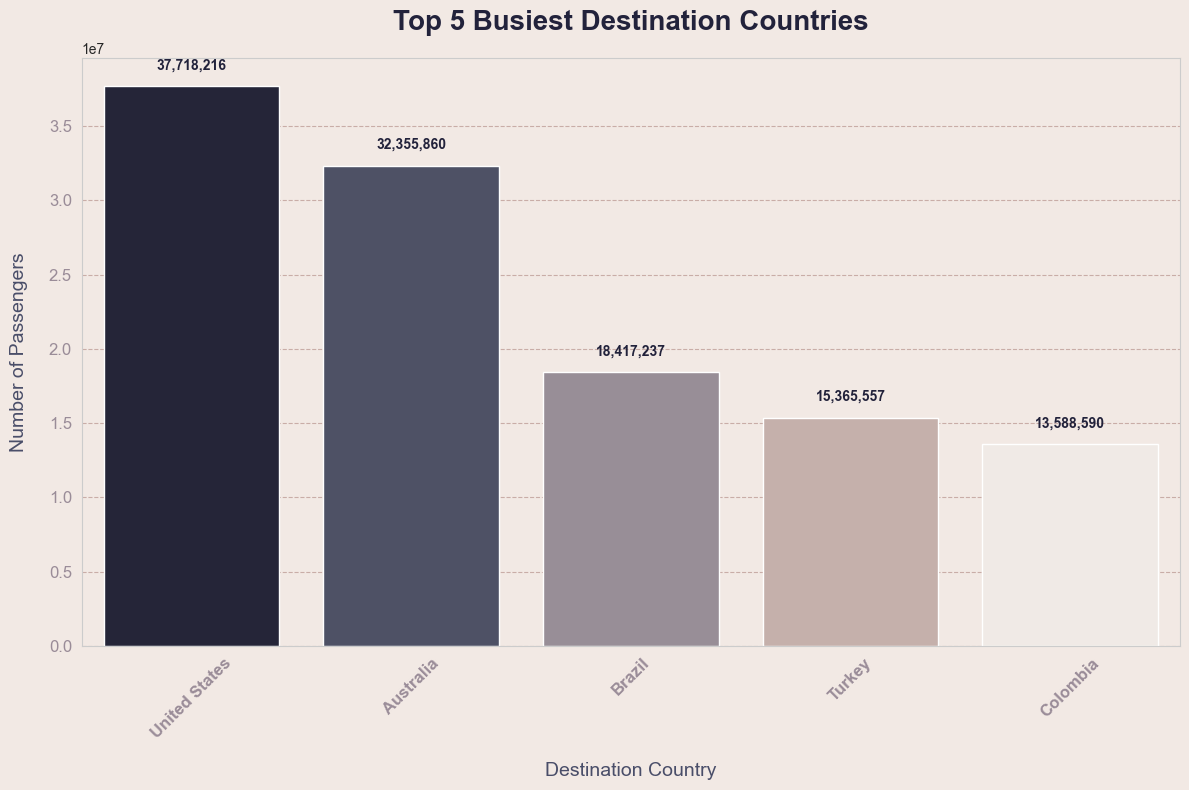

In [59]:
# Define a custom color palette
custom_palette = ['#22223b', '#4a4e69', '#9a8c98', '#c9ada7', '#f2e9e4']

# Set Seaborn style and custom colors
sns.set_style("whitegrid", {
    "axes.facecolor": "#f2e9e4",    # Light background
    "figure.facecolor": "#f2e9e4",  # Light figure background
    "grid.color": "#c9ada7",        # Gridline color
    "grid.linestyle": "--"          # Dashed gridlines
})
sns.set_palette(custom_palette)

plt.figure(figsize=(12, 8))  
barplot = sns.barplot(
    x=busiest_destination_countries.index, 
    y=busiest_destination_countries.values, 
    palette=custom_palette
)

plt.title('Top 5 Busiest Destination Countries', fontsize=20, color='#22223b', weight='bold', pad=20)
plt.xlabel('Destination Country', fontsize=14, color='#4a4e69', labelpad=15)
plt.ylabel('Number of Passengers', fontsize=14, color='#4a4e69', labelpad=15)

plt.xticks(rotation=45, fontsize=12, color='#9a8c98', weight='bold')
plt.yticks(fontsize=12, color='#9a8c98')

# Highlight each bar with annotations (showing passenger numbers)
for index, value in enumerate(busiest_destination_countries.values):
    plt.text(
        index, value + 0.03 * max(busiest_destination_countries.values),  # Position text slightly above the bar
        f"{value:,}",  # Add thousands separator
        ha='center', fontsize=10, color='#22223b', weight='bold'
    )

plt.tight_layout()
plt.show()

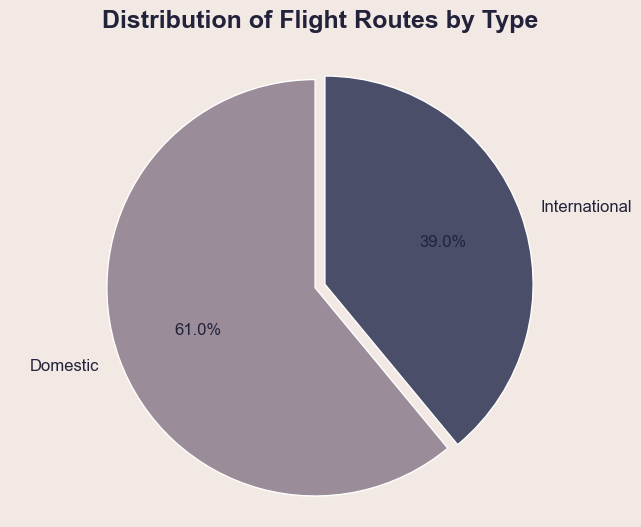

In [60]:
type_counts = df["Type"].value_counts()

# Define a custom color palette
custom_colors = ['#9a8c98', '#4a4e69']  

# Create the pie chart
plt.figure(figsize=(8, 6))  
plt.pie(
    type_counts,
    labels=type_counts.index,
    autopct='%1.1f%%',     # Show percentages with 1 decimal place
    colors=custom_colors,  # Use the updated color palette
    startangle=90,         # Rotate the start of the pie chart for better readability
    explode=(0.05, 0),     # Slightly separate the Domestic slice for emphasis
    textprops={'fontsize': 12, 'color': '#22223b'}  # Customize text properties
)

plt.title(
    "Distribution of Flight Routes by Type",
    fontsize=18,
    color='#22223b',
    weight='bold',
    pad=20  
)
plt.axis('equal')
plt.show()

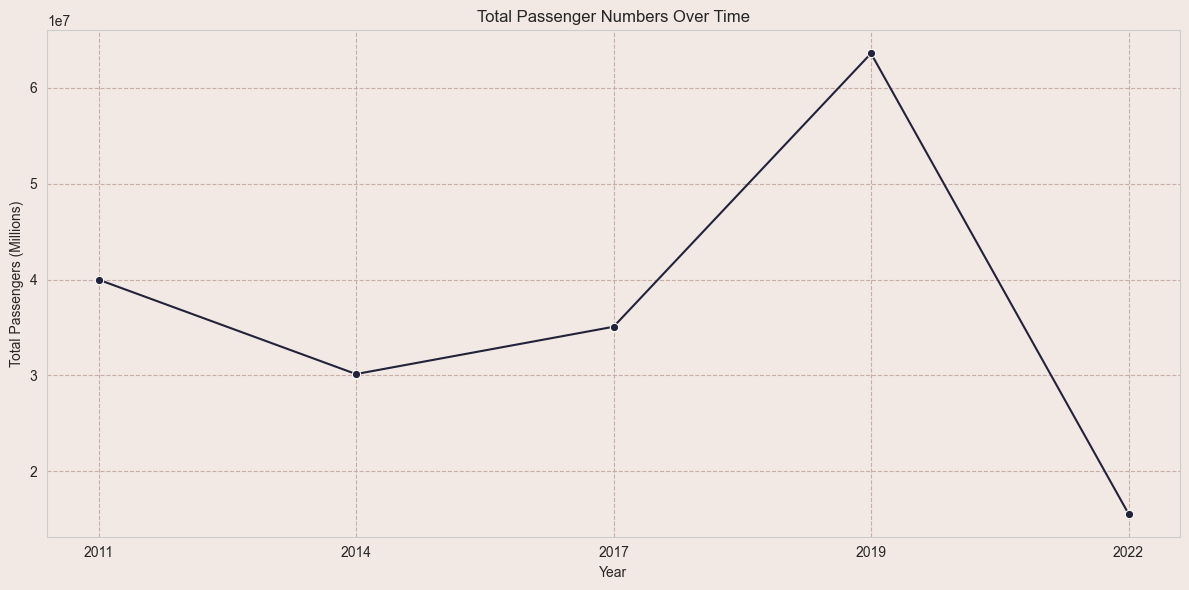

In [49]:
# Visualization 1: Passenger Numbers Over Time
plt.figure(figsize=(12, 6))
passengers_by_year = df.groupby("Year")["Passengers"].sum().reset_index()
sns.lineplot(x="Year", y="Passengers", data=passengers_by_year, marker="o")
plt.title("Total Passenger Numbers Over Time")
plt.xlabel("Year")
plt.ylabel("Total Passengers (Millions)")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_12112\2416424397.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
C:\Users\Dell\AppData\Local\Temp\ipykernel_12112\2416424397.py:14: UserWarning: 
The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.
  barplot = sns.barplot(


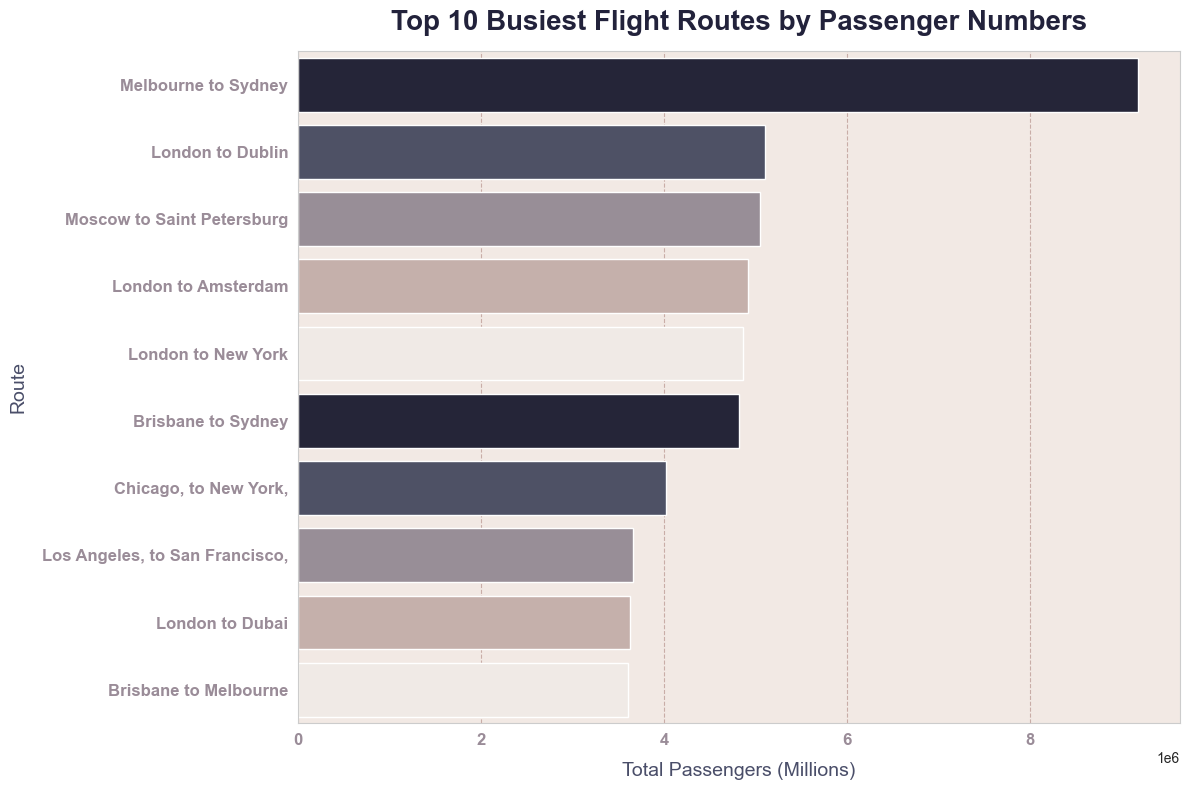

In [62]:
# Set Seaborn style and custom colors
sns.set_style("whitegrid", {
    "axes.facecolor": "#f2e9e4",   # Light background for the plot
    "grid.color": "#c9ada7",       # Subtle gridline color
    "grid.linestyle": "--"         # Dashed gridlines
})
sns.set_palette(custom_palette)

df["Route"] = df["From"] + " to " + df["To"]
top_routes = df.groupby("Route")["Passengers"].sum().reset_index().sort_values("Passengers", ascending=False).head(10)

# Create the barplot
plt.figure(figsize=(12, 8))  
barplot = sns.barplot(
    x="Passengers", 
    y="Route", 
    data=top_routes, 
    palette=custom_palette  
)

plt.title(
    "Top 10 Busiest Flight Routes by Passenger Numbers", 
    fontsize=20, 
    color="#22223b", 
    weight="bold", 
    pad=15  
)
plt.xlabel("Total Passengers (Millions)", fontsize=14, color="#4a4e69", labelpad=10)
plt.ylabel("Route", fontsize=14, color="#4a4e69", labelpad=10)

plt.xticks(fontsize=12, color="#9a8c98", weight="bold")
plt.yticks(fontsize=12, color="#9a8c98", weight="bold")

plt.tight_layout()
plt.show()

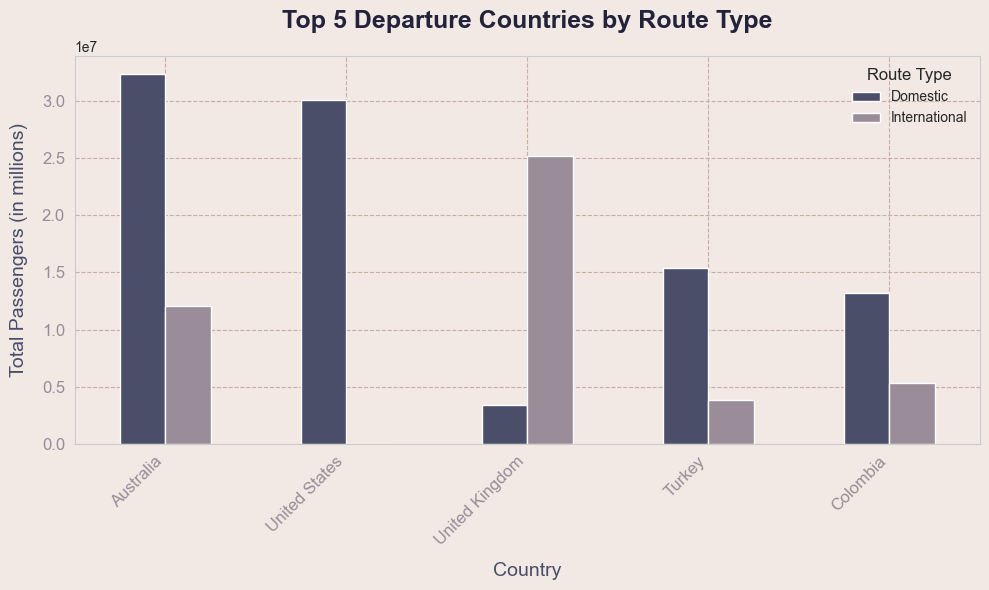

In [61]:
# Prepare data for the plot
top_departure_countries = df.groupby(["From_Country", "Type"])["Passengers"].sum().unstack().fillna(0)
top_departure_countries["Total"] = top_departure_countries.sum(axis=1)
top_departure_countries = top_departure_countries.sort_values("Total", ascending=False).head(5).drop(columns="Total")

custom_colors = ['#4a4e69', '#9a8c98']  

# Create the stacked bar chart with Seaborn
top_departure_countries.plot(
    kind="bar", 
    figsize=(10, 6), 
    color=custom_colors  
)

plt.title(
    "Top 5 Departure Countries by Route Type", 
    fontsize=18, 
    color="#22223b", 
    weight="bold", 
    pad=20  # Add padding to the title for better spacing
)
plt.xlabel("Country", fontsize=14, color="#4a4e69", labelpad=10)
plt.ylabel("Total Passengers (in millions)", fontsize=14, color="#4a4e69", labelpad=10)

# Customize tick labels
plt.xticks(fontsize=12, color="#9a8c98", rotation=45, ha="right")
plt.yticks(fontsize=12, color="#9a8c98")

# Add a legend with improved styling
plt.legend(
    title="Route Type", 
    title_fontsize=12, 
    fontsize=10, 
    loc="upper right", 
    frameon=False
)

# Adjust layout for a cleaner look
plt.tight_layout()

# Show the plot
plt.show()

In [66]:
# Aggregate data to get total passengers per route
df["Route"] = df["From"] + " to " + df["To"]
route_data = df.groupby(["Route", "From", "To", "From_Lat", "From_Lon", "To_Lat", "To_Lon"])["Passengers"].sum().reset_index()

# Select top 10 busiest routes for visualization
top_routes = route_data.sort_values("Passengers", ascending=False).head(10)

# Create an interactive map
m = folium.Map(location=[20, 0], zoom_start=2, tiles="CartoDB positron")

# Add a custom label for "Palestine" with enhanced styling and tooltip
palestine_center = [31.5, 34.5]  # Approximate coordinates for the center of the region
folium.Marker(
    location=palestine_center,
    tooltip="Palestine - Center of the region",
    popup=folium.Popup(
        html="""
        <div style="text-align: center;">
            <div style="font-size: 18pt; font-weight: bold; font-style: italic; color: #800000;">
                🇵🇸 Palestine
            </div>
        </div>
        """, 
        max_width=250
    ),
    icon=folium.DivIcon(
        html="""
        <div style="
            padding: 5px 10px; 
            font-size: 16pt; 
            font-weight: bold; 
            font-style: italic; 
            color: #bc4749; 
            text-align: center;">
            Palestine
        </div>
        """
    )
).add_to(m)

# Add a feature group for better organization
routes_group = folium.FeatureGroup(name="Flight Routes")
markers_group = folium.FeatureGroup(name="Airport Markers")

# Iterate through the top routes and add them to the map
for _, row in top_routes.iterrows():
    start = (row["From_Lat"], row["From_Lon"])
    end = (row["To_Lat"], row["To_Lon"])
    passenger_count = row["Passengers"]
    
    # Add departure marker
    folium.CircleMarker(
        location=start,
        radius=6,
        color="green",
        fill=True,
        fill_color="green",
        tooltip=f"Departure: {row['From']}",
        popup=folium.Popup(f"""
        <b>Departure:</b> {row['From']}<br>
        <b>Latitude:</b> {row['From_Lat']}<br>
        <b>Longitude:</b> {row['From_Lon']}
        """, max_width=250)
    ).add_to(markers_group)
    
    # Add destination marker
    folium.CircleMarker(
        location=end,
        radius=6,
        color="red",
        fill=True,
        fill_color="red",
        tooltip=f"Destination: {row['To']}",
        popup=folium.Popup(f"""
        <b>Destination:</b> {row['To']}<br>
        <b>Latitude:</b> {row['To_Lat']}<br>
        <b>Longitude:</b> {row['To_Lon']}
        """, max_width=250)
    ).add_to(markers_group)
    
    # Add gradient route line
    line_weight = 2 + passenger_count / max(top_routes["Passengers"]) * 5  # Scale line weight dynamically
    folium.PolyLine(
        locations=[start, end],
        color="gray",
        weight=line_weight,
        popup=folium.Popup(f"""
        <b>Route:</b> {row['Route']}<br>
        <b>Passengers:</b> {row['Passengers']:,}
        """, max_width=300)
    ).add_to(routes_group)
    
    # Add midpoint marker
    mid_lat = (row["From_Lat"] + row["To_Lat"]) / 2
    mid_lon = (row["From_Lon"] + row["To_Lon"]) / 2
    folium.Marker(
        location=[mid_lat, mid_lon],
        icon=folium.Icon(icon="plane", prefix="fa", color="blue"),
        tooltip=f"Midpoint of {row['Route']}",
        popup=folium.Popup(f"""
        <b>Midpoint of Route:</b> {row['Route']}
        """, max_width=250)
    ).add_to(routes_group)

# Add feature groups to the map
routes_group.add_to(m)
markers_group.add_to(m)

# Add MeasureControl for scale and measurement
m.add_child(MeasureControl(primary_length_unit='kilometers'))

# Fit map bounds to include all routes and markers
m.fit_bounds(routes_group.get_bounds())

# Add a legend (using a custom HTML div)
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 250px; height: 140px; 
            background-color: white; z-index:1000; font-size:14px; 
            border:2px solid grey; padding: 10px;">
    <b>Legend</b><br>
    <div style="display: flex; align-items: center;">
        <div style="width: 10px; height: 10px; background-color: green; margin-right: 8px;"></div> Departure
    </div>
    <div style="display: flex; align-items: center;">
        <div style="width: 10px; height: 10px; background-color: red; margin-right: 8px;"></div> Destination
    </div>
    <div style="display: flex; align-items: center;">
        <div style="width: 10px; height: 10px; background-color: gray; margin-right: 8px;"></div> Route (Thickness = Traffic)
    </div>
    <div style="display: flex; align-items: center;">
        <div style="width: 10px; height: 10px; background-color: blue; margin-right: 8px;"></div> Midpoint
    </div>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Add fullscreen plugin
Fullscreen().add_to(m)

# Save the map as an interactive HTML page
m.save("interactive_flight_map.html")
print("interactive map saved to 'interactive_flight_map.html'")
m

interactive map saved to 'interactive_flight_map.html'


In [53]:
df

,From,To,Type,Year,Passengers,From_Country,To_Country,From_Lat,From_Lon,To_Lat,To_Lon,Route
0,London,Dublin,International,2011,5106040,United Kingdom,Ireland,51.489334,-0.144055,53.349379,-6.260559,London to Dublin
1,Moscow,Saint Petersburg,Domestic,2011,5051518,Russia,Russia,55.625578,37.606392,59.960674,30.158655,Moscow to Saint Petersburg
2,London,Amsterdam,International,2011,4920551,United Kingdom,Netherlands,51.489334,-0.144055,52.373080,4.892453,London to Amsterdam
3,London,New York,International,2011,4869777,United Kingdom,United States,51.489334,-0.144055,40.712728,-74.006015,London to New York
4,London,Dubai,International,2011,3630407,United Kingdom,United Arab Emirates,51.489334,-0.144055,25.074282,55.188539,London to Dubai
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"Atlanta,","Chicago,",Domestic,2014,2720000,United States,United States,33.748992,-84.390264,41.875562,-87.624421,"Atlanta, to Chicago,"
96,"Chicago,","Minneapolis,",Domestic,2014,2720000,United States,United States,41.875562,-87.624421,44.977300,-93.265469,"Chicago, to Minneapolis,"
97,"Atlanta,","New York,",Domestic,2014,2600000,United States,United States,33.748992,-84.390264,40.712728,-74.006015,"Atlanta, to New York,"
98,"Atlanta,","Orlando,",Domestic,2014,2620000,United States,United States,33.748992,-84.390264,28.542111,-81.379030,"Atlanta, to Orlando,"


In [54]:
# import pandas as pd
# from pymongo import MongoClient

# # Connect to MongoDB
# try:
#     client = MongoClient("mongodb://localhost:27017/")
#     print("Successfully connected to MongoDB")

#     # Create or access the database
#     db = client["flight_routes_db"]

#     # Create or access the collection
#     collection = db["flight_routess"]

#     # Convert DataFrame to list of dictionaries (MongoDB documents)
#     records = df.to_dict("records")

#     # Drop the collection if it exists (equivalent to if_exists='replace')
#     collection.drop()

#     # Insert the records into the collection
#     collection.insert_many(records)
#     print(f"Processed data saved to MongoDB collection 'flight_routess' with {collection.count_documents({})} documents")

#     # Verify by querying the database (first 5 documents)
#     sample_data = collection.find().limit(5)
#     print("\nSample data from the database:")
#     sample_df = pd.DataFrame(list(sample_data))  # Convert back to DataFrame for display
#     print(sample_df)

# except Exception as err:
#     print(f"Error: {err}")

# finally:
#     # Close the connection
#     client.close()
#     print("MongoDB connection closed")

In [55]:
# Filter rows where Australia is either the From_Country or To_Country
australia_data = df[df["From_Country"].str.contains("Australia", na=False) | df["To_Country"].str.contains("Australia", na=False)]

# Display the filtered data
print("Flight Routes Involving Australia:")
australia_data

Flight Routes Involving Australia:


,From,To,Type,Year,Passengers,From_Country,To_Country,From_Lat,From_Lon,To_Lat,To_Lon,Route
40,Melbourne,Sydney,Domestic,2019,9181932,Australia,Australia,-37.814245,144.963173,-33.869844,151.208285,Melbourne to Sydney
41,Brisbane,Sydney,Domestic,2019,4820704,Australia,Australia,-27.468968,153.023499,-33.869844,151.208285,Brisbane to Sydney
42,Brisbane,Melbourne,Domestic,2019,3608479,Australia,Australia,-27.468968,153.023499,-37.814245,144.963173,Brisbane to Melbourne
43,Gold Coast,Sydney,Domestic,2019,2733449,Australia,Australia,-28.002373,153.414599,-33.869844,151.208285,Gold Coast to Sydney
44,Adelaide,Melbourne,Domestic,2019,2538061,Australia,Australia,-34.928181,138.599931,-37.814245,144.963173,Adelaide to Melbourne
45,Gold Coast,Melbourne,Domestic,2019,2122157,Australia,Australia,-28.002373,153.414599,-37.814245,144.963173,Gold Coast to Melbourne
46,Melbourne,Perth,Domestic,2019,2110125,Australia,Australia,-37.814245,144.963173,-31.955893,115.860585,Melbourne to Perth
47,Adelaide,Sydney,Domestic,2019,1878741,Australia,Australia,-34.928181,138.599931,-33.869844,151.208285,Adelaide to Sydney
48,Perth,Sydney,Domestic,2019,1692031,Australia,Australia,-31.955893,115.860585,-33.869844,151.208285,Perth to Sydney
49,Melbourne,Hobart,Domestic,2019,1670181,Australia,Australia,-37.814245,144.963173,-42.882509,147.328123,Melbourne to Hobart
